In [1]:
import sys
sys.path.append('../')

import os

import cqt
import cqt.env.mkt_env as env 
import cqt.env.mkt_env_spot as envspot
import cqt.ledger.ledger as ledger
import cqt.datagen as dg
import cqt.dbutility.dbutility as db
import cqt.strats.strategy as stg
import cqt.strats.strategy_long_short_average as stg_ls
import pandas as pd
import pickle

from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import matplotlib.collections as collections
from talib.abstract import *
import copy

In [2]:
data = pd.read_csv('../data/webdata/Gemini_BTCUSD_d_20200126.csv',skiprows=1)
data.rename(columns={'Open': 'price_open', 'High': 'price_high', 'Low': 'price_low', 'Close': 'price_close', 'Volume BTC':'volume_traded','Date':'time_close'},inplace=True)
df_btc=dg.IndexedData("","",data)

config = {'asset_type': 'spot'}
model_btc = env.MktEnv([])
comp_btc = envspot.MktEnvSpot('btc', df_btc, config)
comp_btc.data=comp_btc.data.sort_index()
model_btc.insert_section(comp_btc)


In [3]:
prices = copy.deepcopy(comp_btc.data)
prices.rename(columns={'price_open': 'open', 'price_high': 'high', 'price_low': 'low', 'price_close': 'close', 'volume_traded': 'volume'}, inplace=True)
close = pd.Series(prices['close'].values)
sma15 = SMA(prices, timeperiod=15)
sma60 = SMA(prices, timeperiod=60)
rsi = RSI(prices, timeperiod=14)
atr = ATR(prices, timeperiod=7)

In [66]:
prices.loc[datetime(2020,1,1):datetime(2020,1,10),['1day_l','7day_l','15day_l','30day_l']]

,1day_l,7day_l,15day_l,30day_l
time_close,,,,
2020-01-01,-0.032097,0.120808,0.214602,0.0
2020-01-02,0.055883,0.126008,0.281581,0.0
2020-01-03,0.002703,0.116990,0.214752,0.0
2020-01-04,-0.000143,0.091211,0.183309,0.0
2020-01-05,0.055898,0.111724,0.173546,0.0
2020-01-06,0.050985,0.044737,0.122900,0.0
2020-01-07,-0.014277,0.081940,0.061970,0.0
2020-01-08,-0.027606,0.095931,0.043441,0.0
2020-01-09,0.047427,0.114450,0.077387,0.0


In [49]:
import numpy as np

b=prices.close.diff(1).values[1:]


In [50]:
(8603-7300)/7300

0.17849315068493152

In [30]:
b=np.append(b,0)

In [31]:
prices['1day_l']=b/prices['close']


In [32]:
b=prices.close.diff(7).values[7:]

In [33]:
b=np.append(b,[0]*7)

In [35]:
prices['7day_l']=b/prices['close']
#len(prices.close)

In [39]:
prices.drop(['range_open','range_close','range_high','range_low','period_abs_return','period_log_return'], axis=1, inplace=True)

In [51]:
b=prices.close.diff(15).values[15:]
b=np.append(b,[0]*15)
prices['15day_l']=b/prices['close']

In [52]:
b=prices.close.diff(30).values[30:]
b=np.append(b,[0]*30)
prices['30day_l']=b/prices['close']

In [ ]:
data=prices.loc[datetime(2019,1,1):datetime(2020,1,1),['1day_l','7day_l','15day_l','30day_l']]

In [72]:
Covariance = np.cov(np.stack(data.values, axis = 1))
print(Covariance)

[[0.0013671  0.00131234 0.00138332 0.00125707]
 [0.00131234 0.00959104 0.00991579 0.00861886]
 [0.00138332 0.00991579 0.02259851 0.02167018]
 [0.00125707 0.00861886 0.02167018 0.04539905]]


In [74]:
from scipy import stats
stats.pearsonr(data['1day_l'].values, data['7day_l'].values)

(0.3624206649442246, 8.399010358440522e-13)

In [76]:
stats.pearsonr(data['1day_l'].values, data['15day_l'].values)

(0.24887532236720142, 1.4280903461631176e-06)

In [75]:
stats.pearsonr(data['1day_l'].values, data['30day_l'].values)

(0.15956426195754012, 0.0021997924838698304)

In [77]:
stats.pearsonr(data['7day_l'].values, data['15day_l'].values)

(0.6735259886956946, 1.0300895626239192e-49)

In [78]:
stats.pearsonr(data['7day_l'].values, data['30day_l'].values)

(0.4130415613165217, 1.6377357351116503e-16)

In [79]:
stats.pearsonr(data['15day_l'].values, data['30day_l'].values)

(0.6765488883357548, 2.620134441588468e-50)

In [55]:
import talib as tb
def technical_indicators_df(daily_data):
        """
        Assemble a dataframe of technical indicator series for a single stock
        """
        o = daily_data['open'].values
        c = daily_data['close'].values
        h = daily_data['high'].values
        l = daily_data['low'].values
        v = daily_data['volume'].astype(float).values
        # define the technical analysis matrix

        # Most data series are normalized by their series' mean
        ta = pd.DataFrame()
        ta['MA5'] = tb.MA(c, timeperiod=5) 
        ta['MA10'] = tb.MA(c, timeperiod=10)
        ta['MA20'] = tb.MA(c, timeperiod=20) 
        ta['MA60'] = tb.MA(c, timeperiod=60) 
        ta['MA120'] = tb.MA(c, timeperiod=120) 
        ta['MA5'] = tb.MA(v, timeperiod=5) 
        ta['MA10'] = tb.MA(v, timeperiod=10)
        ta['MA20'] = tb.MA(v, timeperiod=20) 
        ta['ADX'] = tb.ADX(h, l, c, timeperiod=14) 
        ta['ADXR'] = tb.ADXR(h, l, c, timeperiod=14) 
        ta['MACD'] = tb.MACD(c, fastperiod=12, slowperiod=26, signalperiod=9)[0] 
        ta['RSI'] = tb.RSI(c, timeperiod=14) 
        ta['BBANDS_U'] = tb.BBANDS(c, timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)[0] 
        ta['BBANDS_M'] = tb.BBANDS(c, timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)[1] 
        ta['BBANDS_L'] = tb.BBANDS(c, timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)[2] 
        ta['AD'] = tb.AD(h, l, c, v) 
        ta['ATR'] = tb.ATR(h, l, c, timeperiod=14) 
        ta['HT_DC'] = tb.HT_DCPERIOD(c) 
        ta["High/Open"] = h / o
        ta["Low/Open"] = l / o
        ta["Close/Open"] = c / o
        ta.index=daily_data.index
        return ta

In [34]:
data['target']=data.apply(lambda row:1 if row['1day_pl']>0 else -1 ,axis=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [48]:
tb.MA(prices['close'].values, timeperiod=5)

array([     nan,      nan,      nan, ..., 8676.286, 8627.938, 8561.038])

In [56]:
technical_index=technical_indicators_df(prices)

In [52]:
technical_index.index=prices.index

In [61]:
from sklearn.linear_model import Ridge

ridge_model = Ridge(alpha=0.001)

In [64]:
start=816
end=1117
technical_index[start:end].values

array([[7.77575600e+03, 7.90575500e+03, 1.04904280e+04, ...,
        1.00028726e+00, 9.26176497e-01, 9.65134520e-01],
       [7.34011200e+03, 8.01678800e+03, 1.03512050e+04, ...,
        1.14331243e+00, 9.63458163e-01, 1.10508599e+00],
       [7.77205200e+03, 7.80575800e+03, 1.03436290e+04, ...,
        1.04476974e+00, 9.89374556e-01, 1.02773592e+00],
       ...,
       [3.15711800e+03, 2.69162200e+03, 2.75674550e+03, ...,
        1.00943706e+00, 9.97699423e-01, 1.00178256e+00],
       [2.69259800e+03, 2.53032800e+03, 2.75664700e+03, ...,
        1.00373530e+00, 9.97964409e-01, 1.00139351e+00],
       [2.03969600e+03, 2.11931300e+03, 2.66836450e+03, ...,
        1.00139781e+00, 9.96510146e-01, 9.99187209e-01]])

In [65]:
ridge_model.fit(technical_index[start:end].values,data['target'][start:end].values)

Ridge(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [68]:
X_test=technical_index[end:end+10].values
Y_test=data['target'][end:end+10].values
ridge_model.score(X_test,Y_test)

-0.6506522837406914

In [ ]:
lin_est = LinearRegression() # Create an instance of the LinearRegression class
lin_est.fit(X,y) 

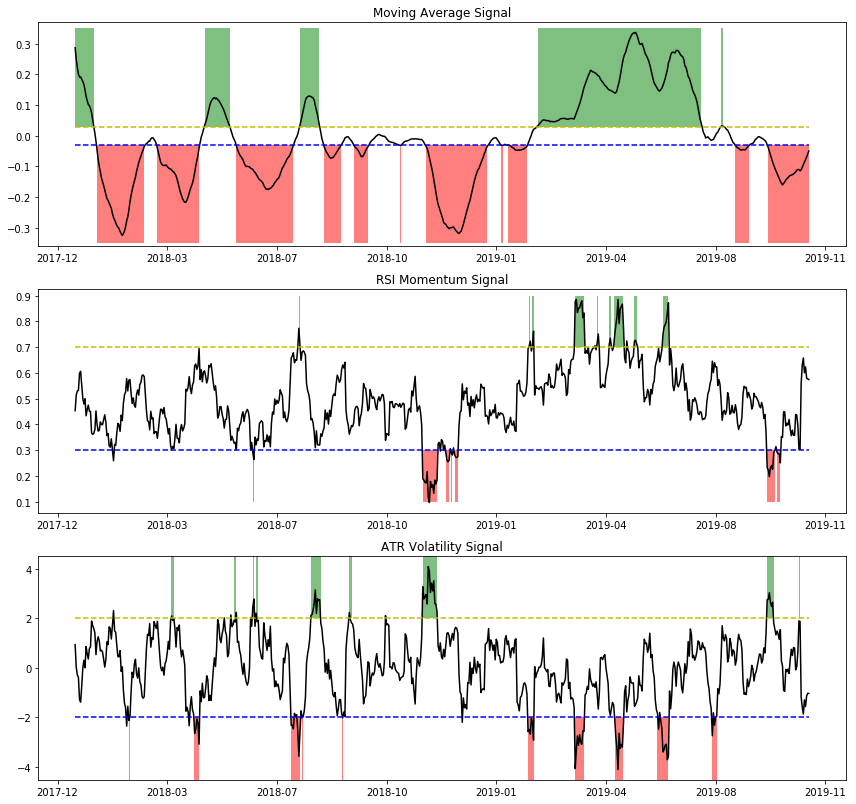

In [19]:
fig_width = 12
fig_height = 12
fig, ax = plt.subplots(3,1, figsize=(fig_width,fig_height))
start=816
end=1486
t=range(start,end)
signal_ma=sma15[start:end]/sma60[start:end]-1
ax[0].set_title('Moving Average Signal')
ax[0].plot(t,signal_ma,'black',t,[0.03]*(end-start),'y--',t,[-0.03]*(end-start),'b--')
collection = collections.BrokenBarHCollection.span_where(t
    , ymin=0.03, ymax=.35, where=signal_ma > 0.03, facecolor='green', alpha=0.5)
ax[0].add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    t, ymin=-.35, ymax=-0.03, where=signal_ma < -0.03, facecolor='red', alpha=0.5)
ax[0].add_collection(collection)
ax[0].set_xticklabels(newlabels)
signal_rsi=rsi[start:end]/100
ax[1].set_title('RSI Momentum Signal')
ax[1].plot(t,signal_rsi,'black',t,[0.7]*(end-start),'y--',t,[0.3]*(end-start),'b--')
collection = collections.BrokenBarHCollection.span_where(t
    , ymin=0.7, ymax=0.9, where=signal_rsi > 0.7, facecolor='green', alpha=0.5)
ax[1].add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    t, ymin=0.1, ymax=0.3, where=signal_rsi < 0.3, facecolor='red', alpha=0.5)
ax[1].add_collection(collection)
ax[1].set_xticklabels(newlabels)
signal_atr=(-close[start:end]+sma15[start:end])/atr[start:end]
ax[2].set_title('ATR Volatility Signal')
ax[2].plot(t,signal_atr,'black',t,[2]*(end-start),'y--',t,[-2]*(end-start),'b--')
collection = collections.BrokenBarHCollection.span_where(t
    , ymin=2, ymax=6, where=signal_atr > 1.8, facecolor='green', alpha=0.5)
ax[2].add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    t, ymin=-6, ymax=-2, where=signal_atr < -1.8, facecolor='red', alpha=0.5)
ax[2].add_collection(collection)
ax[2].set_xticklabels(newlabels)
plt.tight_layout(rect=[0, 0.03, 1, 0.97])

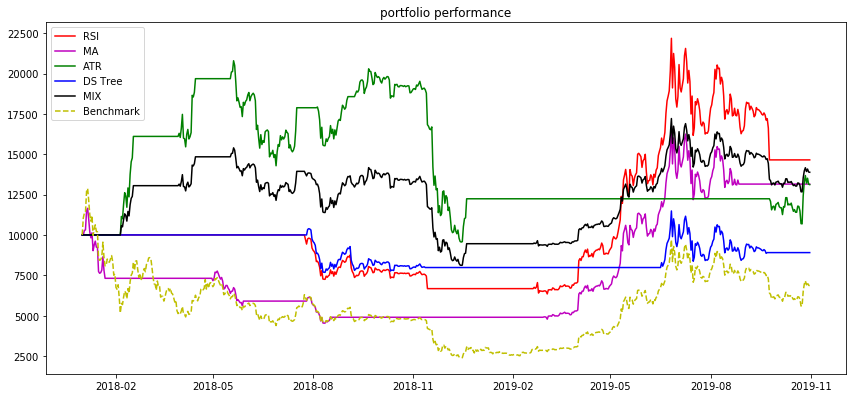

In [229]:
fig_width = 12
fig_height = 6
fig, ax = plt.subplots(figsize=(fig_width,fig_height))
t=report_rsi['date']
ax.plot(t, report_rsi['total'],'r',label='RSI')
ax.plot(t, report_ma['total'],'m',label='MA')
ax.plot(t, report_atr['total'],'g',label='ATR')
ax.plot(t, df['total'],'b',label='DS Tree')
ax.plot(t, (report_atr['total']+report_rsi['total'])*0.5,'black',label='MIX')
ax.plot(t, report_atr['btc_price'] * cash / report_atr['btc_price'][0],'y--',label='Benchmark')
ax.set_title('portfolio performance')#fig.suptitle(strategyName)
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.legend()
plt.show()

In [54]:
import collections
df=pd.DataFrame(collections.OrderedDict({'date':report_atr.date,'btc_price':report_atr.btc_price,'ma_signal':report_ma.ma_signal,
                 'rsi_signal':report_rsi.signal,'atr_signal':report_atr.signal}))


In [97]:
df['diff1']=prices.diff1.values[817:1486]

In [103]:
df['diff3']=prices.diff3.values[819:1488]

In [106]:
df['diff7']=prices.diff7.values[823:1492]
df['diff10']=prices.diff10.values[826:1495]

In [121]:
df.diff1=df.diff1/df.btc_price

In [123]:
df.diff3=df.diff3/df.btc_price
df.diff10=df.diff10/df.btc_price
df.diff7=df.diff7/df.btc_price

In [165]:
df['bull']=df.apply(lambda row: all([row['diff1']>0.005,row['diff3']>0.01,row['diff7']>0.03,row['diff10']>0.03]), axis=1)

In [166]:
df['bear']=df.apply(lambda row: all([row['diff1']<-0.005,row['diff3']<-0.01,row['diff7']<-0.03,row['diff10']<-0.03]), axis=1)

In [168]:
df['target']=df.apply(lambda row:1 if row['bull'] else -1 if row['bear'] else 0,axis=1)

In [146]:
from sklearn import tree
from sklearn.tree.export import export_text

In [152]:
df['bear']=df.apply(lambda row:-1 if row['bear'] else 0,axis=1)

In [237]:
bull_tree=tree.DecisionTreeClassifier()
bull_tree=bull_tree.fit(df[['ma_signal','atr_signal']],df.target)

[Text(142.417,201.996,'X[0] <= -0.5\ngini = 0.426\nsamples = 669\nvalue = [94, 491, 84]'),
 Text(45.5733,157.108,'X[1] <= -0.5\ngini = 0.505\nsamples = 213\nvalue = [37, 141, 35]'),
 Text(22.7867,112.22,'gini = 0.477\nsamples = 28\nvalue = [0, 17, 11]'),
 Text(68.36,112.22,'X[1] <= 0.5\ngini = 0.494\nsamples = 185\nvalue = [37, 124, 24]'),
 Text(45.5733,67.332,'gini = 0.487\nsamples = 174\nvalue = [32, 118, 24]'),
 Text(91.1467,67.332,'gini = 0.496\nsamples = 11\nvalue = [5, 6, 0]'),
 Text(239.26,157.108,'X[1] <= 0.5\ngini = 0.384\nsamples = 456\nvalue = [57, 350, 49]'),
 Text(182.293,112.22,'X[0] <= 0.5\ngini = 0.38\nsamples = 427\nvalue = [49, 329, 49]'),
 Text(136.72,67.332,'X[1] <= -0.5\ngini = 0.363\nsamples = 151\nvalue = [22, 118, 11]'),
 Text(113.933,22.444,'gini = 0.165\nsamples = 11\nvalue = [1, 10, 0]'),
 Text(159.507,22.444,'gini = 0.376\nsamples = 140\nvalue = [21, 108, 11]'),
 Text(227.867,67.332,'X[1] <= -0.5\ngini = 0.387\nsamples = 276\nvalue = [27, 211, 38]'),
 Text(2

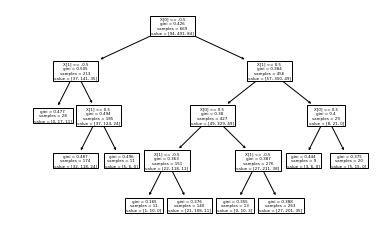

In [238]:
tree.plot_tree(bull_tree)

In [239]:
r = export_text(bull_tree)
print(r)

|--- feature_0 <= -0.50
|   |--- feature_1 <= -0.50
|   |   |--- class: 0
|   |--- feature_1 >  -0.50
|   |   |--- feature_1 <= 0.50
|   |   |   |--- class: 0
|   |   |--- feature_1 >  0.50
|   |   |   |--- class: 0
|--- feature_0 >  -0.50
|   |--- feature_1 <= 0.50
|   |   |--- feature_0 <= 0.50
|   |   |   |--- feature_1 <= -0.50
|   |   |   |   |--- class: 0
|   |   |   |--- feature_1 >  -0.50
|   |   |   |   |--- class: 0
|   |   |--- feature_0 >  0.50
|   |   |   |--- feature_1 <= -0.50
|   |   |   |   |--- class: 0
|   |   |   |--- feature_1 >  -0.50
|   |   |   |   |--- class: 0
|   |--- feature_1 >  0.50
|   |   |--- feature_0 <= 0.50
|   |   |   |--- class: 0
|   |   |--- feature_0 >  0.50
|   |   |   |--- class: 0



In [233]:
df['ds_predict']=bull_tree.predict(df[['rsi_signal','atr_signal']])

In [236]:
df[df.target==1]

,date,btc_price,ma_signal,rsi_signal,atr_signal,diff1,diff3,diff7,diff10,bull,bear,target,ds_predict,total,cash,btc_holding
35,2018-02-05,6892.67,1.0,0.0,0.0,0.114626,0.189670,0.291227,0.453309,True,False,1,0,10000.000000,10000.000000,0.000000
37,2018-02-07,7582.76,1.0,0.0,0.0,0.081400,0.128019,0.250240,0.463847,True,False,1,0,10000.000000,10000.000000,0.000000
41,2018-02-11,8073.90,1.0,0.0,0.0,0.102317,0.174187,0.288474,0.297390,True,False,1,0,10000.000000,10000.000000,0.000000
43,2018-02-13,8519.07,1.0,0.0,0.0,0.112829,0.195392,0.315428,0.192809,True,False,1,0,10000.000000,10000.000000,0.000000
55,2018-02-25,9595.00,1.0,0.0,0.0,0.073476,0.073149,0.195121,0.030147,True,False,1,0,10000.000000,10000.000000,0.000000
95,2018-04-06,6564.06,1.0,0.0,0.0,0.050568,0.031528,0.199858,0.226721,True,False,1,0,10000.000000,10000.000000,0.000000
98,2018-04-09,6771.01,1.0,0.0,0.0,0.008813,0.169750,0.189227,0.221280,True,False,1,0,10000.000000,10000.000000,0.000000
99,2018-04-10,6830.68,1.0,0.0,0.0,0.015921,0.153024,0.155668,0.296429,True,False,1,0,10000.000000,10000.000000,0.000000
100,2018-04-11,6939.43,1.0,0.0,0.0,0.141360,0.152554,0.176898,0.285408,True,False,1,0,10000.000000,10000.000000,0.000000
102,2018-04-13,7875.94,1.0,0.0,0.0,0.015507,0.022388,0.124372,0.134214,True,False,1,0,10000.000000,10000.000000,0.000000


In [222]:
df['total']=df.btc_price*0
df['cash']=df.btc_price*0
df['btc_holding']=df.btc_price*0

In [223]:
df.at[0,'cash']=10000
df.at[0,'total']=10000

In [224]:
for i in range(1,df.shape[0]):
    if df.at[i,'ds_predict']==1:
        if df.at[i-1,'btc_holding']==0:
            df.at[i,'total']=df.at[i-1,'cash']
            df.at[i,'cash']=0
            df.at[i,'btc_holding']=df.at[i,'total']/df.at[i,'btc_price']
        else:
            df.at[i,'btc_holding']=df.at[i-1,'btc_holding']
            df.at[i,'cash']=0
            df.at[i,'total']=df.at[i,'btc_holding']*df.at[i,'btc_price']
            
    elif df.at[i,'ds_predict']==-1: 
        if df.at[i-1,'btc_holding']==0:
            df.at[i,'total']=df.at[i-1,'total']
            df.at[i,'cash']=df.at[i-1,'cash']
            df.at[i,'btc_holding']=0
        else:
            df.at[i,'total']=df.at[i-1,'total']
            df.at[i,'cash']=df.at[i,'total']
            df.at[i,'btc_holding']=0
    else:
        if df.at[i-1,'btc_holding']==0:
            df.at[i,'total']=df.at[i-1,'total']
            df.at[i,'cash']=df.at[i-1,'cash']
            df.at[i,'btc_holding']=0
        else:
            df.at[i,'btc_holding']=df.at[i-1,'btc_holding']
            df.at[i,'cash']=0
            df.at[i,'total']=df.at[i,'btc_holding']*df.at[i,'btc_price']